In [5]:
import matplotlib.font_manager as fm

font_entry = fm.FontEntry(
    fname=r'font/NanumGothic.ttf', 
    name='NanumGothic'
)
fm.fontManager.ttflist.insert(0, font_entry)

plt.rcParams.update({ 'font.family': 'NanumGothic', 'font.size': 14, 'axes.unicode_minus':False })

C:\Users\ck551\AppData\Local\Temp\ipykernel_33608\2733232048.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['시군구명'] = data_df['시군구명'].str.strip().replace('', '세종특별자치시')
C:\Users\ck551\AppData\Local\Temp\ipykernel_33608\2733232048.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df2['시군구명'] = data_df2['시군구명'].str.strip().replace('', '세종특별자치시')


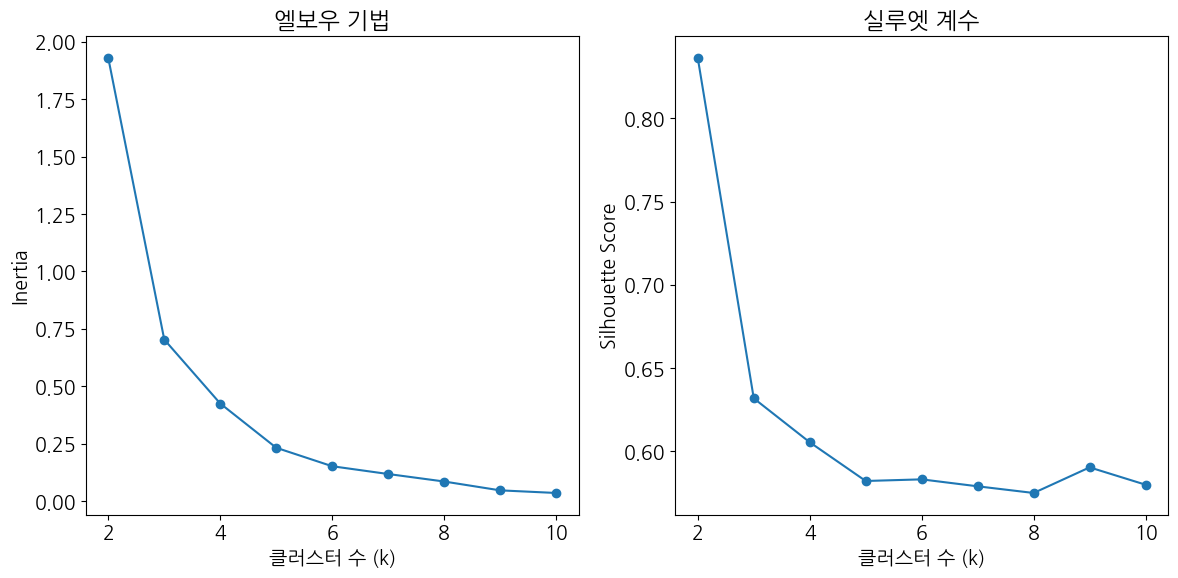

k=2인 지역들:
    시군구명         관광객 밀도
0    가평군  210468.454923
130  연천군  319577.481882
137  영양군  207590.402130
152  울릉군  350968.710871


C:\Users\ck551\AppData\Local\Temp\ipykernel_33608\2733232048.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_map['관광객 밀도'].fillna(mean_density, inplace=True)


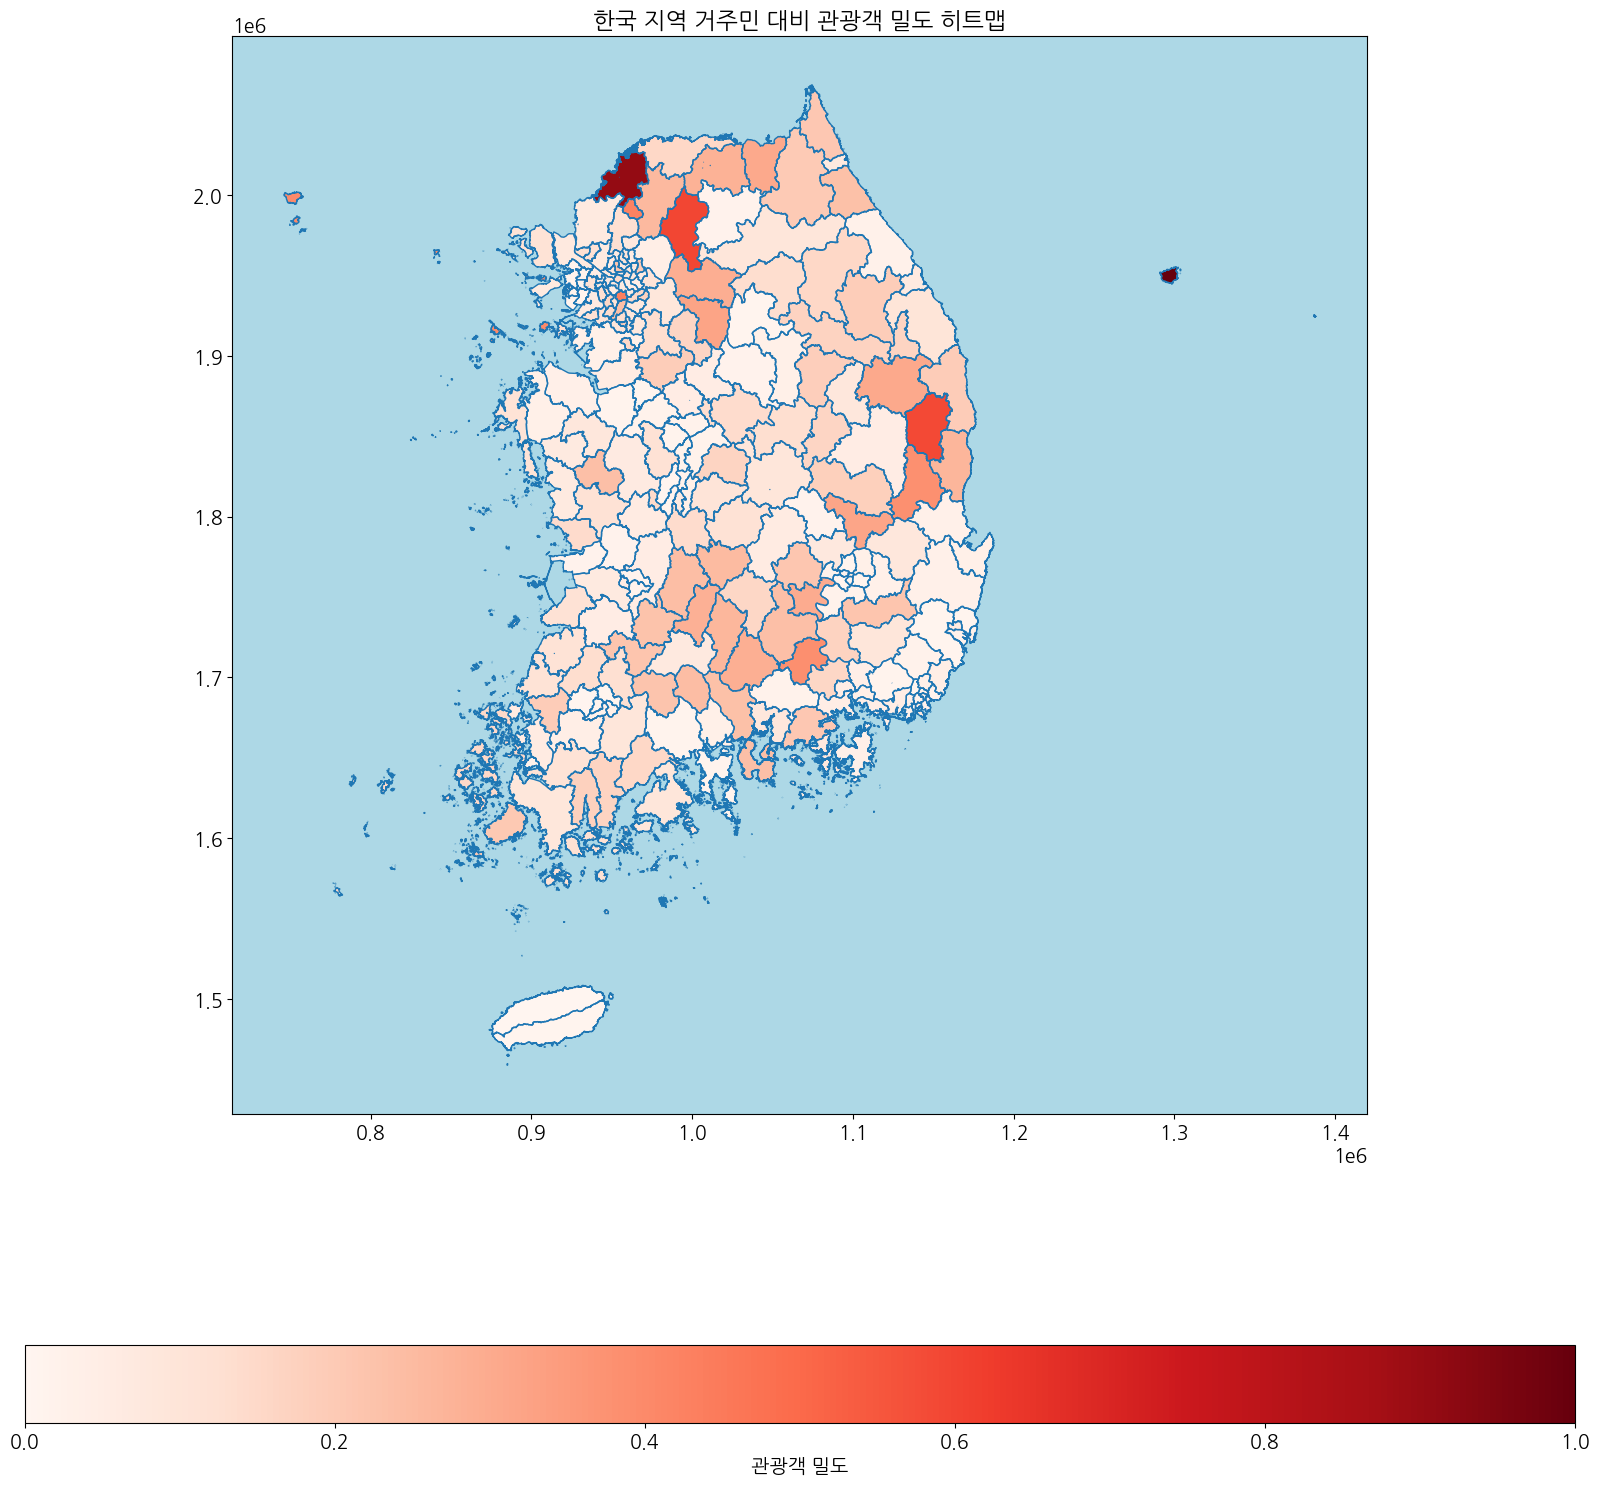

In [58]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# CSV 파일 읽기
X = pd.read_csv('heatMapFile/행정안전부_지역별(행정동) 성별 연령별 주민등록 인구수_20240630.csv', encoding='cp949')
X2 = pd.read_csv('heatMapFile/광역별방문자수.csv', encoding='cp949')

# 불필요한 열 삭제
data_df = X.iloc[:, [3, 5]]  # 시군구명, 인구수 열
data_df2 = X2.iloc[:, [1, 2]]  # 시군구명, 방문자수 열
data_df.columns = ['시군구명', '인구수']
data_df2.columns = ['시군구명', '방문자수']

# 빈 값을 '세종특별자치시'로 대체
data_df['시군구명'] = data_df['시군구명'].str.strip().replace('', '세종특별자치시')
data_df2['시군구명'] = data_df2['시군구명'].str.strip().replace('', '세종특별자치시')

# 데이터 그룹화
data_df_grouped = data_df.groupby('시군구명', as_index=False).agg({'인구수': 'sum'})
data_df2_grouped = data_df2.groupby('시군구명', as_index=False).agg({'방문자수': 'sum'})

# 데이터 병합
merged_data = pd.merge(data_df_grouped, data_df2_grouped, on='시군구명')

# 관광객 밀도 계산
merged_data['관광객 밀도'] = merged_data['방문자수'] / merged_data['인구수']

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data[['관광객 밀도']])
scaled_df = pd.DataFrame(scaled_data, columns=['관광객 밀도'], index=merged_data['시군구명'])

# 엘보우 기법과 실루엣 계수 계산
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# 엘보우 기법 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('엘보우 기법')
plt.xlabel('클러스터 수 (k)')
plt.ylabel('Inertia')

# 실루엣 계수 시각화
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o')
plt.title('실루엣 계수')
plt.xlabel('클러스터 수 (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# KMeans 모델을 k=2로 적합
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_data)

# 클러스터 레이블을 데이터프레임에 추가
merged_data['클러스터'] = kmeans.labels_

# k=2인 지역 필터링
k2_regions = merged_data[merged_data['클러스터'] == 1]  # 클러스터 레이블이 1인 지역을 선택 (0 또는 1 중에서 확인 필요)

# 결과 출력
print("k=2인 지역들:")
print(k2_regions[['시군구명', '관광객 밀도']])


# 한국 시군구 경계 데이터 불러오기
korea_sgg = gpd.read_file('heatMapFile/sig.shp', encoding='cp949')

# 'SIG_KOR_NM'에 대한 인덱스를 설정하여 병합
scaled_df.reset_index(inplace=True)  # 인덱스를 리셋하여 '시군구명' 열을 일반 열로 만듭니다.
scaled_df.rename(columns={'시군구명': 'SIG_KOR_NM'}, inplace=True)  # 열 이름 변경

# 경계 데이터에서 'SIG_KOR_NM'과 정규화된 데이터를 병합
merged_map = korea_sgg.merge(scaled_df, on='SIG_KOR_NM', how='outer')

# 누락된 값을 평균값으로 채우기
mean_density = merged_map['관광객 밀도'].mean()
merged_map['관광객 밀도'].fillna(mean_density, inplace=True)

# 관광객 밀도에 따라 색상 매핑
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
merged_map.boundary.plot(ax=ax, linewidth=1)  # 경계선 그리기
merged_map.plot(column='관광객 밀도', ax=ax, legend=True,
                legend_kwds={'label': "관광객 밀도",
                             'orientation': "horizontal"},
                cmap='Reds', missing_kwds={"color": "lightgrey", "label": "없음"})
# 배경 색 설정
plt.gca().set_facecolor('lightblue')  # 배경 색을 연한 파란색으로 설정

# 제목 설정
plt.title('한국 지역 거주민 대비 관광객 밀도 히트맵')
plt.show()


C:\Users\ck551\AppData\Local\Temp\ipykernel_33608\1630601616.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['시군구명'] = data_df['시군구명'].str.strip().replace('', '세종특별자치시')
C:\Users\ck551\AppData\Local\Temp\ipykernel_33608\1630601616.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df2['시군구명'] = data_df2['시군구명'].str.strip().replace('', '세종특별자치시')
C:\Users\ck551\AppData\Local\Temp\ipykernel_33608\1630601616.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Serie

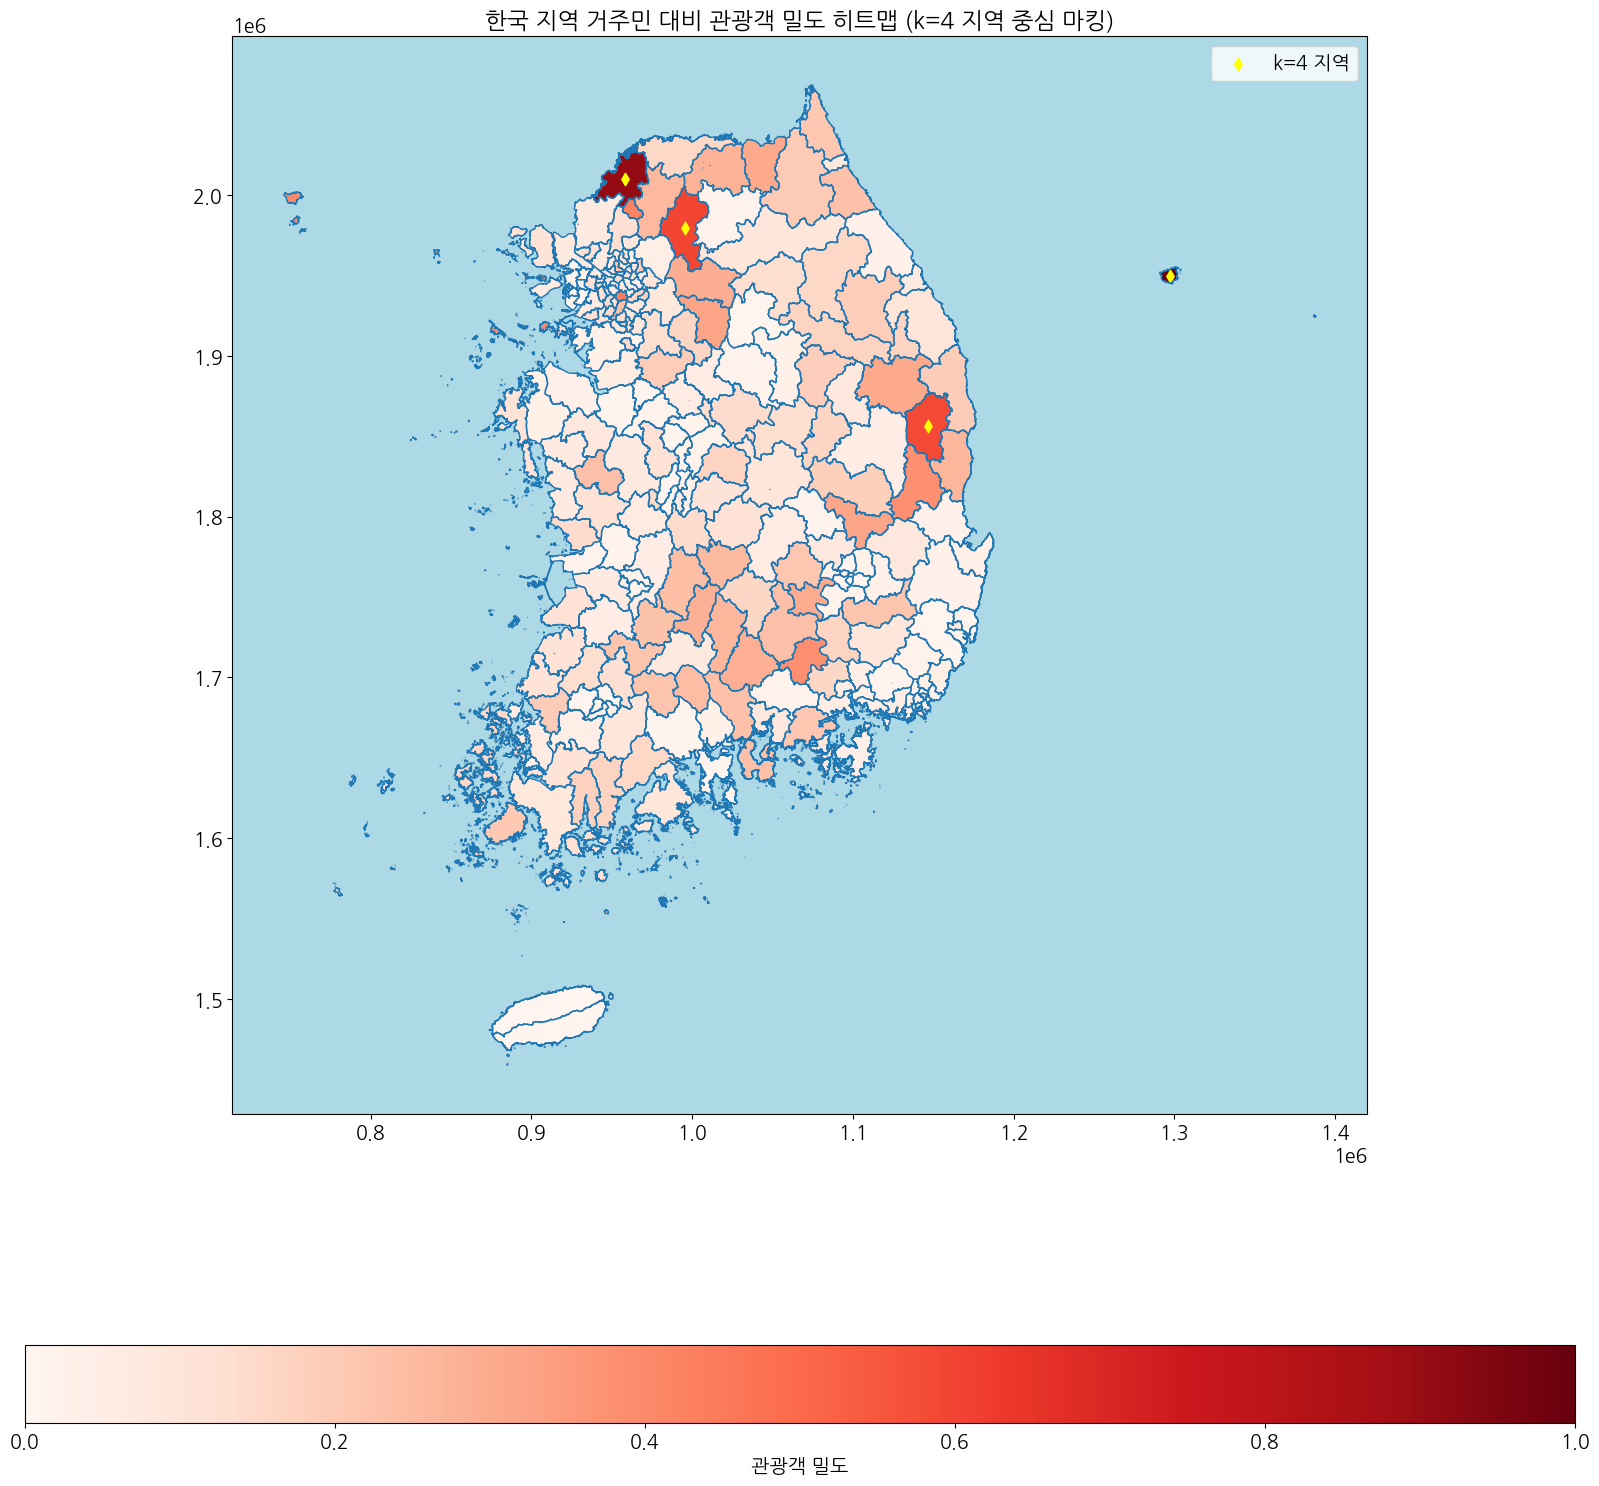

In [60]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# CSV 파일 읽기
X = pd.read_csv('heatMapFile/행정안전부_지역별(행정동) 성별 연령별 주민등록 인구수_20240630.csv', encoding='cp949')
X2 = pd.read_csv('heatMapFile/광역별방문자수.csv', encoding='cp949')

# 불필요한 열 삭제
data_df = X.iloc[:, [3, 5]]  # 시군구명, 인구수 열
data_df2 = X2.iloc[:, [1, 2]]  # 시군구명, 방문자수 열
data_df.columns = ['시군구명', '인구수']
data_df2.columns = ['시군구명', '방문자수']

# 빈 값을 '세종특별자치시'로 대체
data_df['시군구명'] = data_df['시군구명'].str.strip().replace('', '세종특별자치시')
data_df2['시군구명'] = data_df2['시군구명'].str.strip().replace('', '세종특별자치시')

# 데이터 그룹화
data_df_grouped = data_df.groupby('시군구명', as_index=False).agg({'인구수': 'sum'})
data_df2_grouped = data_df2.groupby('시군구명', as_index=False).agg({'방문자수': 'sum'})

# 데이터 병합
merged_data = pd.merge(data_df_grouped, data_df2_grouped, on='시군구명')

# 관광객 밀도 계산
merged_data['관광객 밀도'] = merged_data['방문자수'] / merged_data['인구수']

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data[['관광객 밀도']])
scaled_df = pd.DataFrame(scaled_data, columns=['관광객 밀도'], index=merged_data['시군구명'])

# 엘보우 기법과 실루엣 계수 계산
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# KMeans 모델을 k=4로 적합
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_data)

# 클러스터 레이블을 데이터프레임에 추가
merged_data['클러스터'] = kmeans.labels_

# k=4인 지역 필터링
k4_regions = merged_data[merged_data['클러스터'] == 1]  # 0, 1, 2, 3 중 하나 선택

# 한국 시군구 경계 데이터 불러오기
korea_sgg = gpd.read_file('heatMapFile/sig.shp', encoding='cp949')

# 'SIG_KOR_NM'에 대한 인덱스를 설정하여 병합
scaled_df.reset_index(inplace=True)
scaled_df.rename(columns={'시군구명': 'SIG_KOR_NM'}, inplace=True)

# 경계 데이터에서 'SIG_KOR_NM'과 정규화된 데이터를 병합
merged_map = korea_sgg.merge(scaled_df, on='SIG_KOR_NM', how='outer')

# 누락된 값을 평균값으로 채우기
mean_density = merged_map['관광객 밀도'].mean()
merged_map['관광객 밀도'].fillna(mean_density, inplace=True)


# 관광객 밀도에 따라 색상 매핑
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
merged_map.boundary.plot(ax=ax, linewidth=1)  # 경계선 그리기
merged_map.plot(column='관광객 밀도', ax=ax, legend=True,
                 legend_kwds={'label': "관광객 밀도",
                              'orientation': "horizontal"},
                 cmap='Reds', missing_kwds={"color": "lightgrey", "label": "없음"})

# k=4 군집 지역의 중심 계산 및 마킹
for idx, row in k4_regions.iterrows():
    # 시군구명으로 경도를 찾기
    region_boundary = merged_map[merged_map['SIG_KOR_NM'] == row['시군구명']]
    if not region_boundary.empty:
        # 경계의 중심 계산
        centroid = region_boundary.geometry.centroid
        ax.scatter(centroid.x, centroid.y, color='yellow', marker='d', s=40, label='k=4 지역' if idx == 0 else "")

# 배경 색 설정
plt.gca().set_facecolor('lightblue')  # 배경 색을 연한 파란색으로 설정

# 제목 설정
plt.title('한국 지역 거주민 대비 관광객 밀도 히트맵 (k=4 지역 중심 마킹)')
plt.legend()
plt.show()


C:\Users\ck551\AppData\Local\Temp\ipykernel_33608\2525413304.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['시군구명'] = data_df['시군구명'].str.strip().replace('', '세종특별자치시')
C:\Users\ck551\AppData\Local\Temp\ipykernel_33608\2525413304.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df2['시군구명'] = data_df2['시군구명'].str.strip().replace('', '세종특별자치시')


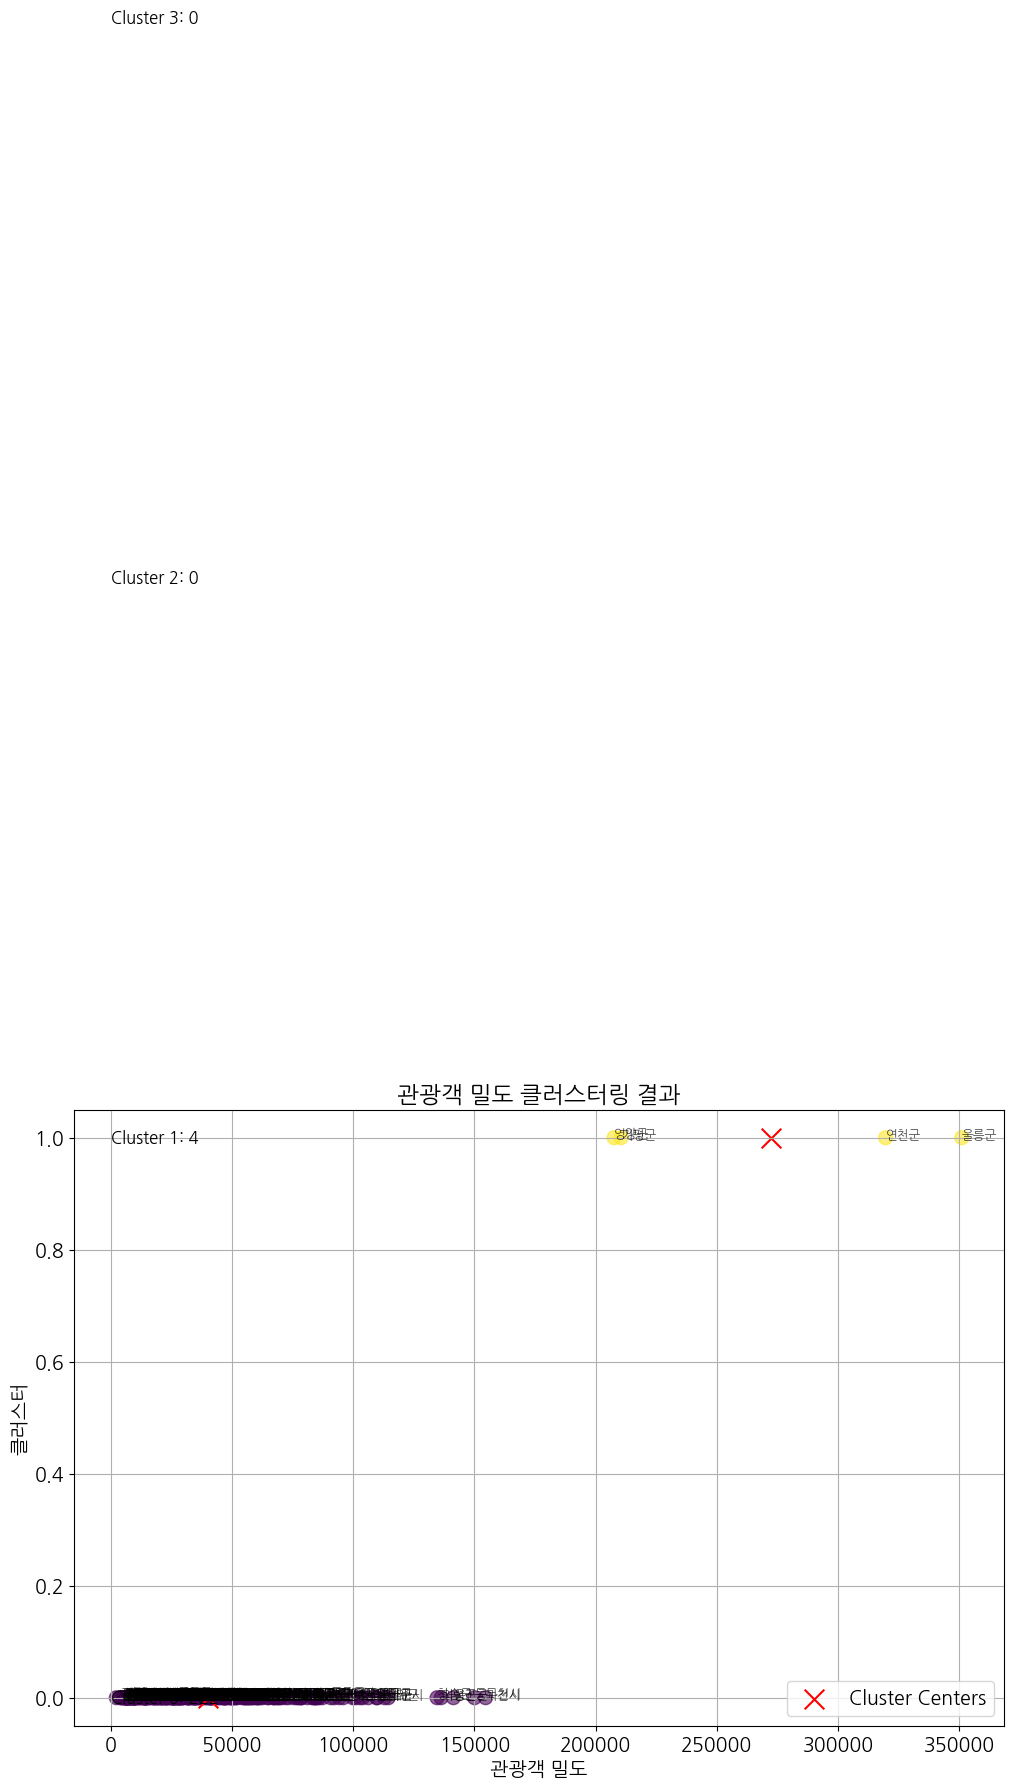

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# CSV 파일 읽기
X = pd.read_csv('heatMapFile/행정안전부_지역별(행정동) 성별 연령별 주민등록 인구수_20240630.csv', encoding='cp949')
X2 = pd.read_csv('heatMapFile/광역별방문자수.csv', encoding='cp949')

# 불필요한 열 삭제
data_df = X.iloc[:, [3, 5]]  # 시군구명, 인구수 열
data_df2 = X2.iloc[:, [1, 2]]  # 시군구명, 방문자수 열
data_df.columns = ['시군구명', '인구수']
data_df2.columns = ['시군구명', '방문자수']

# 빈 값을 '세종특별자치시'로 대체
data_df['시군구명'] = data_df['시군구명'].str.strip().replace('', '세종특별자치시')
data_df2['시군구명'] = data_df2['시군구명'].str.strip().replace('', '세종특별자치시')

# 데이터 그룹화
data_df_grouped = data_df.groupby('시군구명', as_index=False).agg({'인구수': 'sum'})
data_df2_grouped = data_df2.groupby('시군구명', as_index=False).agg({'방문자수': 'sum'})

# 데이터 병합
merged_data = pd.merge(data_df_grouped, data_df2_grouped, on='시군구명')

# 관광객 밀도 계산
merged_data['관광객 밀도'] = merged_data['방문자수'] / merged_data['인구수']

# 관광객 밀도만 클러스터링하는 코드
# 클러스터링을 위한 데이터 준비
tourist_density_data = merged_data[['관광객 밀도']]

# 데이터 정규화
scaler = MinMaxScaler()
scaled_tourist_density = scaler.fit_transform(tourist_density_data)

# KMeans 모델을 k=4로 적합
kmeans_tourist = KMeans(n_clusters=2, random_state=42)
kmeans_tourist.fit(scaled_tourist_density)

# 클러스터 레이블을 데이터프레임에 추가
merged_data['관광객 밀도 클러스터'] = kmeans_tourist.labels_

# 클러스터 결과 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(merged_data['관광객 밀도'], 
                      merged_data['관광객 밀도 클러스터'], 
                      c=merged_data['관광객 밀도 클러스터'], 
                      cmap='viridis', 
                      s=100, 
                      alpha=0.6)

# 지역명 표시
for i in range(len(merged_data)):
    plt.annotate(merged_data['시군구명'][i], 
                 (merged_data['관광객 밀도'][i], merged_data['관광객 밀도 클러스터'][i]), 
                 fontsize=9, 
                 alpha=0.7)

# 클러스터 중심 표시
centers = kmeans_tourist.cluster_centers_
plt.scatter(scaler.inverse_transform(centers), 
            range(len(centers)), 
            c='red', marker='x', s=200, label='Cluster Centers')

# 각 클러스터의 개수 표시
for cluster_num in range(4):
    count = (merged_data['관광객 밀도 클러스터'] == cluster_num).sum()
    plt.text(0, cluster_num, f'Cluster {cluster_num}: {count}', 
             color='black', fontsize=12, verticalalignment='center')

# 레이블 및 제목 설정
plt.title('관광객 밀도 클러스터링 결과')
plt.xlabel('관광객 밀도')
plt.ylabel('클러스터')
plt.legend()
plt.grid()
plt.show()
